In [1]:
# --> Import standard functions from numpy.
import numpy as np
from numpy.random import normal

# --> Import matplotlib and set related parameters.
import matplotlib.pyplot as plt
fig_width = 12

# --> Import SciPy utility functions for linear dynamical systems.
from scipy.signal import lti
from scipy.signal import dlti, dlsim

# --> Import standard linear algebra functions from SciPy.
from scipy.linalg import svd, svdvals
from scipy.linalg import eig, eigvals
from scipy.linalg import norm

# --> Import various DMD algorithms available in PyDMD.
from pydmd import DMD, FbDMD, optDMD

# Tutorial 8 : Comparison of various DMD algorithms

In this tutorial, we perform a thorough comparison of various DMD algorithms available in PyDMD, namely:
- the original DMD algorithm proposed by Schmid (*J. Fluid Mech.*, 2010), see `DMD`
- the optimal closed-form solution given by Héas & Herzet (*arXiv*, 2016), see `optDMD`.

For that purpose, different test cases are considered in order to assess the accuracy, the computational efficiency, the generalization capabilities and the robustness to noise of each method.

Three different test cases will be considered :
- ??
- a chain of 1D harmonic oscillators,
- a nonlinear PDE model.

Although the first two examples are both linear, only one of them has relatively low-rank dynamics satisfying the assumptions onto which DMD relies.

***

## Example #1 : ??

***

## Example #2 : Chain of coupled 1D harmonic oscillators

The second example we'll consider is that of a chain of slightly damped 1D harmonic oscillators with nearest-neighbours coupling. Defining the state-vector as

$$
    \mathbf{x} = \begin{bmatrix} \mathbf{q} & \mathbf{p} \end{bmatrix}^T,
$$

where $\mathbf{q}$ is the position and $\mathbf{p}$ is the momentum, our linear system can be written as

$$
    \displaystyle \frac{\mathrm{d}}{\mathrm{d}t} \begin{bmatrix} \mathbf{q} \\ \mathbf{p} \end{bmatrix} = \begin{bmatrix} \mathbf{0} & \mathbf{I} \\ -\mathbf{K} & -\mathbf{G} \end{bmatrix} \begin{bmatrix} \mathbf{q} \\ \mathbf{p} \end{bmatrix},
$$

with $\mathbf{K}$ and $\mathbf{G}$ being the stiffness and friction matrices, respectively. It must be emphasized that, because we consider $N=50$ identifical oscillators, this system does not exhibit low-rank dynamics. Eventhough it does not satisfy the assumptions for which DMD really is useful, this system will nonetheless enable us to further highlight the benefits of using the optimal solution proposed by Héas & Herzet (arXiv, 2016) as opposed to the other algorithms currently available in PyDMD. The following cells provide a utility function to create a `scipy.signal.dlti` instance for our system, and generates a training time-series starting from a random initial condition.

In [2]:
def harmonic_oscillators(N=10, omega=0.1, alpha=0.2, gamma=0.05, dt=1.0):
    
    """
    This function builds the discrete-time model of a chain of N coupled
    weakly damped harmonic oscillators. Note that all oscillators are
    identical to one another and that we assume a nearest-neighbour coupling.
    
    Parameters
    ----------
    N : integer
        The number of oscillators forming the chain (default 10).
        
    omega : float
            The natural frequency of the base oscillator (default 0.1).
            
    alpha : float
            The nearest-neighbour coupling strength (default 0.2).
            
    gamma : float
            The damping parameter (default 0.05).
            
    dt    : float
            The sampling period for the continuous-to-discrete time conversion (default 1.0).
    
    Returns
    -------
    dsys :  scipy.signal.dlti
            The corresponding discrete-time state-space model.
    
    """
    
    # --> Miscellaneous imports.
    from scipy.sparse import diags, identity, bmat, block_diag
    
    # --> Build the stiffness matrix.
    K_ii = np.ones((N,)) * (omega**2/2.0 + alpha) # Self-coupling.
    K_ij = np.ones((N-1,)) * (-alpha/2.0) # Nearest-neighbor coupling.
    K = diags([K_ij, K_ii, K_ij], offsets=[-1, 0, 1]) # Assembles the stiffness matrix.
    
    # --> Build the friction matrix.
    G = gamma * identity(N)
    
    # --> Build the dynamic matrix.
    A = bmat([[None, identity(N)], [-K, -G]])
    
    # --> Build the control matrix.
    B = bmat([[0*identity(N)], [identity(N)]])
    
    # --> Build the observation matrix.
    C = identity(2*N)
    
    # --> Build the feedthrough matrix.
    D = bmat([[0*identity(N)], [0*identity(N)]])
    
    # --> SciPy continuous-time LTI object.
    sys = lti(A.toarray(), B.toarray(), C.toarray(), D.toarray())
    
    # --> Return the discrete-time equivalent.
    return sys.to_discrete(dt)

In [3]:
# --> Get the discrete-time LTI model.
N = 50 # Number of oscillators (each has 2 degrees of freedom)
dsys = harmonic_oscillators(N=N, dt=1.0) # Build the model.

Text(0.5, 0.98, 'Training dataset')

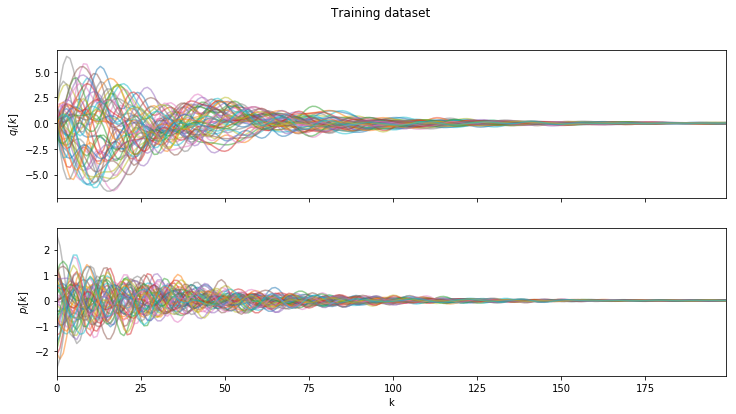

In [211]:
####################################
#####                          #####
#####     TRAINING DATASET     #####
#####                          #####
####################################

# --> Training initial condition.
x0_train = normal(
    loc=0.0,
    scale=1.0,
    size=(dsys.A.shape[1])
)

# --> Run simulation to generate dataset.
t, _, x_train = dlsim(dsys, np.zeros((200, dsys.inputs)), x0=x0_train)

# --> Setup the figure.
fig, axes = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(fig_width, fig_width/2),
)

# --> Plot the oscillators' positions.
axes[0].plot(
    t, x_train[:, :dsys.inputs],
    alpha=0.5,
)

# --> Add decorators.
axes[0].set_ylabel(r"$q_i[k]$")

# --> Plot the oscillators'velocities.
axes[1].plot(
    t, x_train[:, dsys.inputs:],
    alpha=0.5,
)

# --> Add decorators.
axes[1].set_xlabel(r"k")
axes[1].set_xlim(t.min(), t.max())

axes[1].set_ylabel(r"$p_i[k]$")

# --> Figure's title.
fig.suptitle(r"Training dataset")

Let us now fit our models, namely vanilla DMD (Schmid, *J. Fluid Mech.*, 2010) and the closed-form solution DMD (Héas & Herzet, *arXiv*, 2016).

In [212]:
def rank_sensitvity(dsys, x_train):
    
    dmd_test_error, optdmd_test_error = list(), list()
    dmd_train_error, optdmd_train_error = list(), list()
    
    for i in range(1, dsys.A.shape[0]+1):
        
        # --> Fit the DMD model (Schmid's algorithm)
        dmd = DMD(svd_rank=i).fit(x_train.T)
        
        # --> Fit the DMD model (optimal closed-form solution)
        optdmd = optDMD(svd_rank=i).fit(x_train.T)
        
        # --> Split the training data into input/output snapshots.
        y_train = x_train.T[:, 1:].T
        X_train = x_train.T[:, :-1].T

        # --> One-step ahead prediction using both DMD models.
        y_predict_dmd = dmd.predict(X_train.T).T
        y_predict_opt = optdmd.predict(X_train.T).T

        # --> Compute the one-step ahead prediction error.
        dmd_train_error.append( norm(y_predict_dmd-y_train)/norm(y_train) )
        optdmd_train_error.append( norm(y_predict_opt-y_train)/norm(y_train) ) 
        
        # --> Evaluate the error on test data.
        dmd_error, optdmd_error = list(), list()
        for _ in range(100):
            # --> Test initial condition.
            x0_test = normal(
                loc=0.0,
                scale=1.0,
                size=(dsys.A.shape[1])
            )

            # --> Run simulation to generate dataset.
            t, _, x_test = dlsim(dsys, np.zeros((250, dsys.inputs)), x0=x0_test)
            
            # --> Split the training data into input/output snapshots.
            y_test = x_test.T[:, 1:].T
            X_test = x_test.T[:, :-1].T

            # --> One-step ahead prediction using both DMD models.
            y_predict_dmd = dmd.predict(X_test.T).T
            y_predict_opt = optdmd.predict(X_test.T).T

            # --> Compute the one-step ahead prediction error.
            dmd_error.append( norm(y_predict_dmd-y_test)/norm(y_test) )
            optdmd_error.append( norm(y_predict_opt-y_test)/norm(y_test) ) 

        # --> Store the error for rank i DMD.
        dmd_test_error.append( np.asarray(dmd_error) )
        optdmd_test_error.append( np.asarray(optdmd_error) )

    # --> Complete rank-sensitivity.
    dmd_test_error = np.asarray(dmd_test_error)
    optdmd_test_error = np.asarray(optdmd_test_error)
    
    dmd_train_error = np.asarray(dmd_train_error)
    optdmd_train_error = np.asarray(optdmd_train_error)
    
    return dmd_train_error, dmd_test_error, optdmd_train_error, optdmd_test_error

In [213]:
def plot_rank_sensitivity(dmd_train_error, dmd_test_error, optdmd_train_error, optdmd_test_error):
    
    # --> Generate figure.
    fig, axes = plt.subplots(
        1, 2, 
        figsize=(fig_width, fig_width/4),
        sharey=True,
    )
    
    # --> Plot the vanilla DMD error.    
    axes[0].plot(
        np.arange(1, dmd_test_error.shape[0]+1),
        dmd_train_error,
    )

        
    axes[0].plot(
        np.arange(1, dmd_test_error.shape[0]+1),
        optdmd_train_error,
        ls="--",
    )

    # --> Add decorators.
    axes[0].set_xlim(0, 100)
    
    
    
    # --> Plot the vanilla DMD error.
    axes[1].plot(
        np.arange(1, dmd_test_error.shape[0]+1),
        np.median(dmd_test_error, axis=1)
    )
    
    axes[1].fill_between(
        np.arange(1, dmd_test_error.shape[0]+1),
        np.mean(dmd_test_error, axis=1) + 2*np.std(dmd_test_error, axis=1),
        np.mean(dmd_test_error, axis=1) - 2*np.std(dmd_test_error, axis=1),
        alpha=0.25,
    )
    
    axes[1].plot(
        np.arange(1, dmd_test_error.shape[0]+1),
        np.median(optdmd_test_error, axis=1),
        ls="--",
    )
    
    axes[1].fill_between(
        np.arange(1, optdmd_test_error.shape[0]+1),
        np.mean(optdmd_test_error, axis=1) + 2*np.std(optdmd_test_error, axis=1),
        np.mean(optdmd_test_error, axis=1) - 2*np.std(optdmd_test_error, axis=1),
        alpha=0.25,
    )
    
    # --> Add decorators.
    axes[1].set_ylim(0, 1)
    axes[1].set_xlim(0, 100)

    return

In [214]:
# --> Run the rank-sensitivity analysis.
dmd_train_error, dmd_test_error, optdmd_train_error, optdmd_test_error = rank_sensitvity(dsys, x_train)

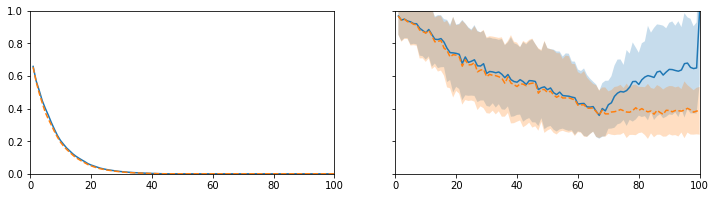

In [215]:
# --> Plot the results.
plot_rank_sensitivity(dmd_train_error, dmd_test_error, optdmd_train_error, optdmd_test_error)

In [117]:
# --> Split the training data into input/output snapshots.
y_train = x_train.T[:, 1:].T
X_train = x_train.T[:, :-1].T

# --> One-step ahead prediction using both DMD models.
y_predict_dmd = dmd.predict(X_train.T).T
y_predict_opt = optdmd.predict(X_train.T).T

# --> Compute the one-step ahead prediction error.
print( norm(y_predict_dmd-y_train)/norm(y_train) )
print( norm(y_predict_opt-y_train)/norm(y_train) ) 

8.718249933759164e-15
2.369123587008188e-15


In [118]:
# --> Split the training data into input/output snapshots.
y_test = x_test.T[:, 1:].T
X_test = x_test.T[:, :-1].T

# --> One-step ahead prediction using both DMD models.
y_predict_dmd = dmd.predict(X_test.T).T
y_predict_opt = optdmd.predict(X_test.T).T

# --> Compute the one-step ahead prediction error.
print( norm(y_predict_dmd-y_test)/norm(y_test) )
print( norm(y_predict_opt-y_test)/norm(y_test) ) 

0.4573866946797173
0.2407257136833712


In [119]:
dmd_test_error = list()
optdmd_test_error = list()

for i in range(10000):

    x0_test = normal(
        loc=0.0,
        scale=1.0,
        size=(dsys.A.shape[1])
    )

    # --> Run simulation to generate dataset.
    t, _, x_test = dlsim(dsys, np.zeros((250, dsys.inputs)), x0=x0_test)

    # --> Split the training data into input/output snapshots.
    y_test = x_test.T[:, 1:].T
    X_test = x_test.T[:, :-1].T

    # --> One-step ahead prediction using both DMD models.
    y_predict_dmd = dmd.predict(X_test.T).T
    y_predict_opt = optdmd.predict(X_test.T).T

    # --> Compute the one-step ahead prediction error.
    dmd_test_error.append( norm(y_predict_dmd-y_test)/norm(y_test) )
    optdmd_test_error.append( norm(y_predict_opt-y_test)/norm(y_test) ) 
    
dmd_test_error = np.asarray(dmd_test_error)    
optdmd_test_error = np.asarray(optdmd_test_error)

(array([  3.,   1.,   6.,  13.,  20.,  20.,  47.,  56.,  88., 112., 130.,
        144., 201., 247., 291., 301., 340., 355., 423., 423., 397., 442.,
        441., 439., 441., 418., 405., 413., 381., 335., 334., 275., 253.,
        222., 218., 217., 182., 139., 145., 102.,  95.,  77.,  72.,  65.,
         61.,  51.,  26.,  35.,  24.,  17.,  13.,  11.,   3.,   8.,   8.,
          5.,   2.,   2.,   1.,   0.,   1.,   0.,   1.,   2.]),
 array([0.10082334, 0.10702688, 0.11323043, 0.11943398, 0.12563753,
        0.13184107, 0.13804462, 0.14424817, 0.15045172, 0.15665527,
        0.16285881, 0.16906236, 0.17526591, 0.18146946, 0.187673  ,
        0.19387655, 0.2000801 , 0.20628365, 0.21248719, 0.21869074,
        0.22489429, 0.23109784, 0.23730138, 0.24350493, 0.24970848,
        0.25591203, 0.26211557, 0.26831912, 0.27452267, 0.28072622,
        0.28692977, 0.29313331, 0.29933686, 0.30554041, 0.31174396,
        0.3179475 , 0.32415105, 0.3303546 , 0.33655815, 0.34276169,
        0.34896524, 0.

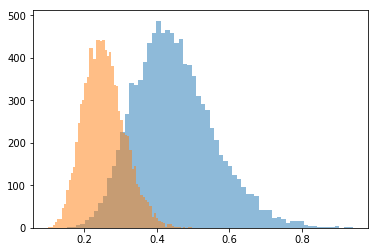

In [120]:
plt.hist(dmd_test_error, bins=64, alpha=0.5)
plt.hist(optdmd_test_error, bins=64, alpha=0.5)

In [121]:
# --> Compute the singular values of the true system.
vals_true = svdvals(dsys.A)

# --> Compute the singular values of the DMD-approximated system.
#     NOTE : Schmid's algorithm (J. Fluid Mech., 2010)
vals_dmd = svdvals(dmd._Atilde)

# --> Compute the singular values of the DMD-approximated system.
#     NOTE : Optimal closed-form solution.
vals_optdmd = svdvals(optdmd._Atilde)

(0, 50)

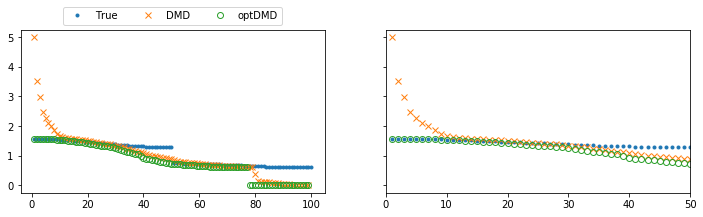

In [122]:
fig, axes = plt.subplots(
    1, 2,
    sharey=True,
    figsize=(fig_width, fig_width/4)
)

axes[0].plot(
    np.arange(1, len(vals_true)+1), vals_true,
    ".",
    label=r"True",
)

axes[0].plot(
    np.arange(1, len(vals_dmd)+1), vals_dmd,
    "x",
    label=r"DMD"
)

axes[0].plot(
    np.arange(1, len(vals_optdmd)+1), vals_optdmd,
    "o",
    mfc="None",
    label=r"optDMD",
)

axes[0].legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1.0),
    ncol=3,
)



axes[1].plot(
    np.arange(1, len(vals_true)+1), vals_true,
    ".",
    label=r"True",
)

axes[1].plot(
    np.arange(1, len(vals_dmd)+1), vals_dmd,
    "x",
    label=r"DMD"
)

axes[1].plot(
    np.arange(1, len(vals_optdmd)+1), vals_optdmd,
    "o",
    mfc="None",
    label=r"optDMD",
)

axes[1].set_xlim(0, 50)

***

## Example #3 : Nonlinear PDE model